In [22]:
import warnings

import geopandas
import libpysal
import momepy
import osmnx
import pandas

from clustergram import Clustergram

import matplotlib.pyplot as plt
from bokeh.io import output_notebook
from bokeh.plotting import show

output_notebook()

Loading BokehJS ...

In [ ]:
place = 'Kyiv, Ukraine'
local_crs = 5514

In [ ]:
geopandas.tools.geocode(place).explore()

## Prepare static data

#### Buildings

In [28]:
buildings = geopandas.read_file('../data/buildings_preprocessed.gpkg', layer="buildings")

#### Streets

In [24]:
streets = geopandas.read_file('../data/streets.gpkg', layer="streets")

# Generated data

## Tessellation

In [29]:
len(buildings)

59261

In [38]:
buildings.head()

uID                                           geometry
0    0  POLYGON ((400715.451 -1047066.528, 400798.992 ...
1    1  POLYGON ((411512.314 -1039314.466, 411523.660 ...
2    2  POLYGON ((411551.985 -1039399.946, 411563.241 ...
3    3  POLYGON ((411535.943 -1039300.928, 411574.307 ...
4    4  POLYGON ((411589.050 -1039278.554, 411600.700 ...

In [33]:
limit = momepy.buffered_limit(buildings)

%time tessellation = momepy.Tessellation(buildings, "uID", limit, verbose=False, segment=1)
tessellation = tessellation.tessellation

<timed exec>:1: UserWarning: Tessellation contains MultiPolygon elements. Initial objects should  be edited. `unique_id` of affected elements: [46790, 53952, 53951, 17924, 11135, 53950, 51919, 56834, 51917, 51918, 31793, 31794, 31795, 31796, 31791, 31805, 56840, 31803, 31798, 31799, 31800, 31801, 31251, 31265, 31259, 31071, 56839, 31074, 31077, 31261, 46083, 56848, 46082, 31070, 31073, 31076, 56838, 31069, 31072, 31075, 31139, 31258, 46081, 31004, 31003, 31007, 31068, 31301, 31067, 31138, 31137, 31066, 31136, 31134, 31141, 31143, 56837, 31135, 31146, 31144, 31142, 31140, 31001, 31000, 31005, 31002, 31006, 30996, 59163, 56836, 30999, 30998, 30997, 41819, 12719, 53163, 38442, 9331, 42350, 41804, 2624, 16723, 55409, 51886, 23726, 51824, 51885, 7787, 42206, 22171, 42207, 57040, 57038, 57039, 31085, 39744, 39742, 20805, 20901, 59164, 58817, 59155, 59156, 39976, 12620, 48123, 48122, 53709, 19842, 40534, 6649, 48616, 59144, 46443, 46442, 9523, 43035, 15542, 45630].


CPU times: user 18min 56s, sys: 58.7 s, total: 19min 55s
Wall time: 20min 28s


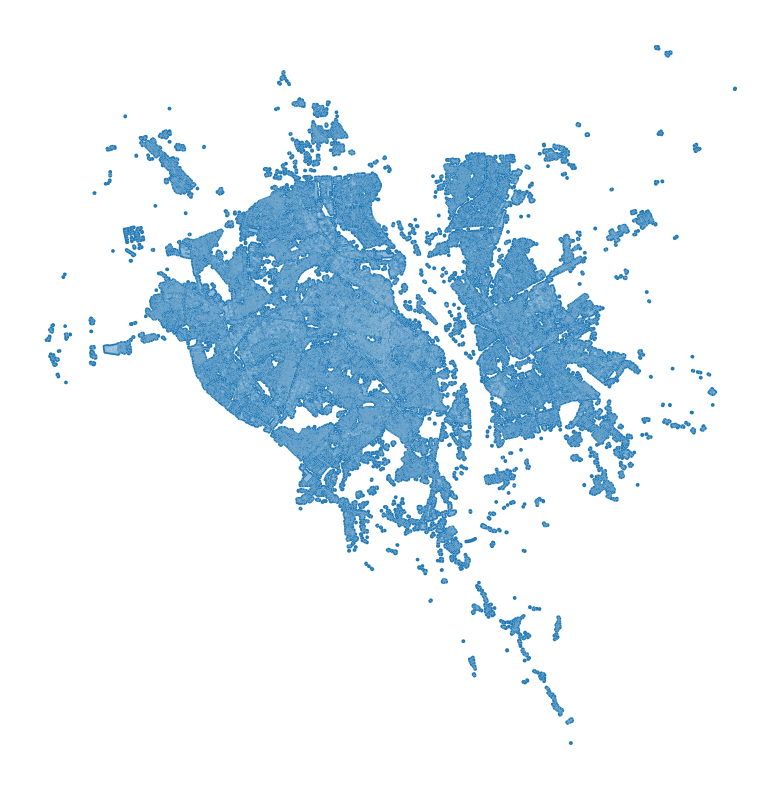

In [35]:
f, ax = plt.subplots(figsize=(10, 10))
tessellation.plot(ax=ax, color='white', alpha=.5)
ax.set_axis_off()
plt.show()

In [ ]:
tessellation.to_file("../data/tessellation.gpkg", driver='GPKG', layer="tessellation")

## Link streets

In [40]:
buildings = buildings.sjoin_nearest(streets, max_distance=1000, how="left")
buildings.head()

/Users/petrokvartsianyi/opt/miniconda3/envs/kyiv/lib/python3.10/site-packages/geopandas/geodataframe.py:2298: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:5514
Right CRS: EPSG:3857

  return geopandas.sjoin_nearest(


uID                                           geometry  index_right     nID
0    0  POLYGON ((400715.451 -1047066.528, 400798.992 ...       4282.0  4282.0
1    1  POLYGON ((411512.314 -1039314.466, 411523.660 ...       8780.0  8780.0
2    2  POLYGON ((411551.985 -1039399.946, 411563.241 ...       8780.0  8780.0
3    3  POLYGON ((411535.943 -1039300.928, 411574.307 ...       8780.0  8780.0
4    4  POLYGON ((411589.050 -1039278.554, 411600.700 ...       8780.0  8780.0

In [41]:
buildings = buildings.drop_duplicates("uID").drop(columns="index_right")
tessellation = tessellation.merge(buildings[['uID', 'nID']], on='uID', how='left')

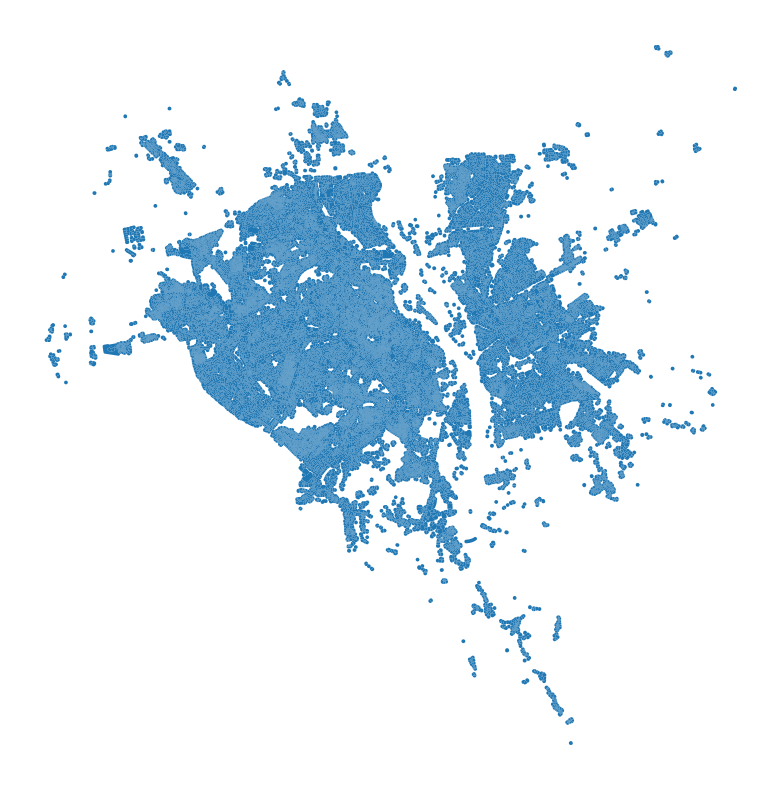

In [44]:
f, ax = plt.subplots(figsize=(10, 10))
tessellation.plot(ax=ax)
ax.set_axis_off()
plt.show()

# Measure

## Dimensions

In [45]:
buildings["area"] = buildings.area
tessellation["area"] = tessellation.area
streets["length"] = streets.length

## Shape

In [47]:
buildings['eri'] = momepy.EquivalentRectangularIndex(buildings).series
buildings['elongation'] = momepy.Elongation(buildings).series
tessellation['convexity'] = momepy.Convexity(tessellation).series
streets["linearity"] = momepy.Linearity(streets).series

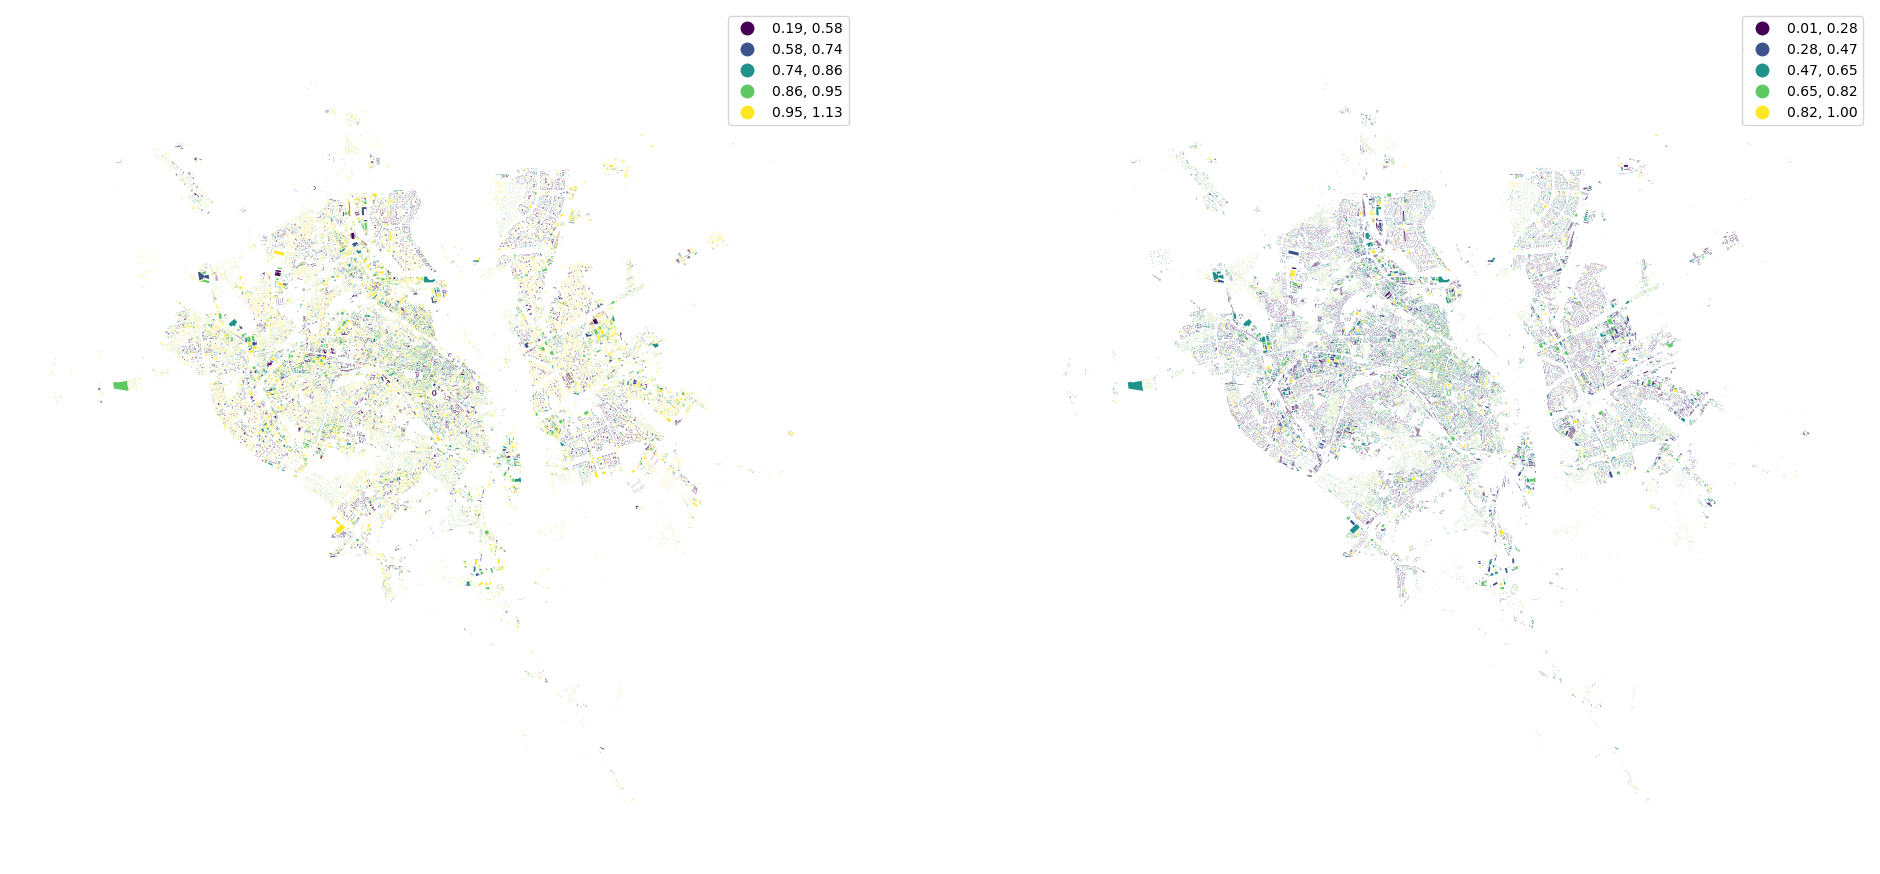

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

buildings.plot("eri", ax=ax[0], scheme="natural_breaks", legend=True)
buildings.plot("elongation", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_axis_off()
ax[1].set_axis_off()

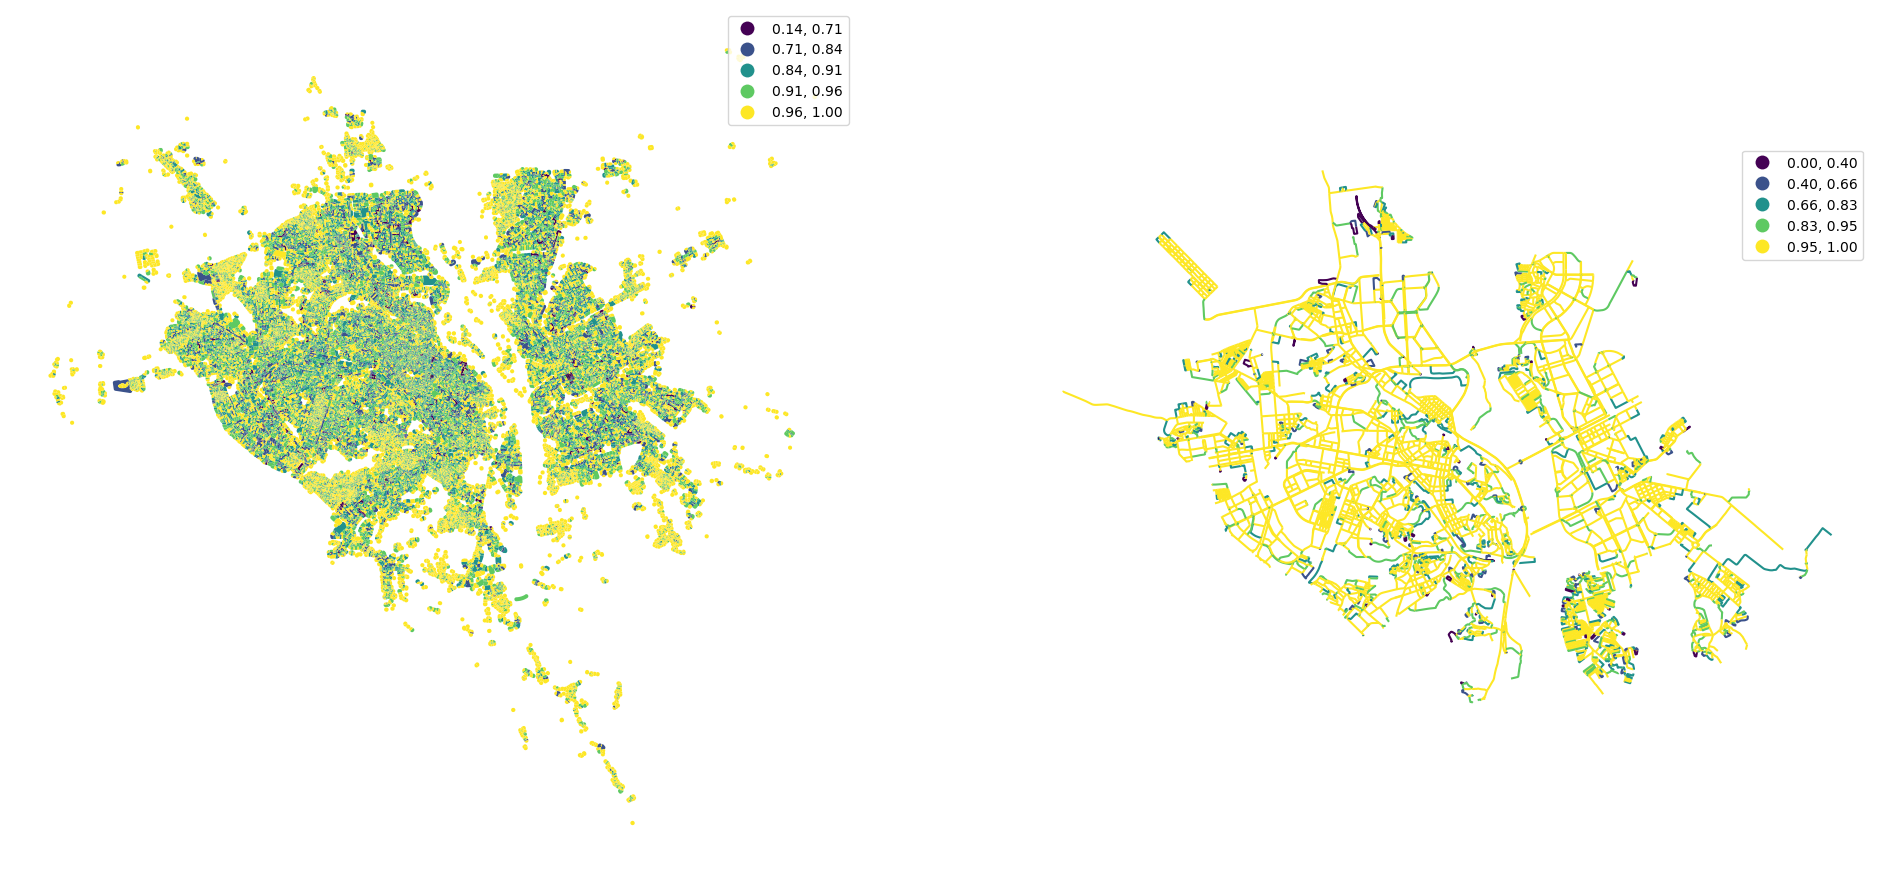

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

tessellation.plot("convexity", ax=ax[0], scheme="natural_breaks", legend=True)
streets.plot("linearity", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_axis_off()
ax[1].set_axis_off()

## Spatial distribution

/Users/petrokvartsianyi/opt/miniconda3/envs/kyiv/lib/python3.10/site-packages/momepy/distribution.py:135: FutureWarning: The `query_bulk()` method is deprecated and will be removed in GeoPandas 1.0. You can use the `query()` method instead.
  inp, res = gdf.sindex.query_bulk(gdf.geometry, predicate="intersects")


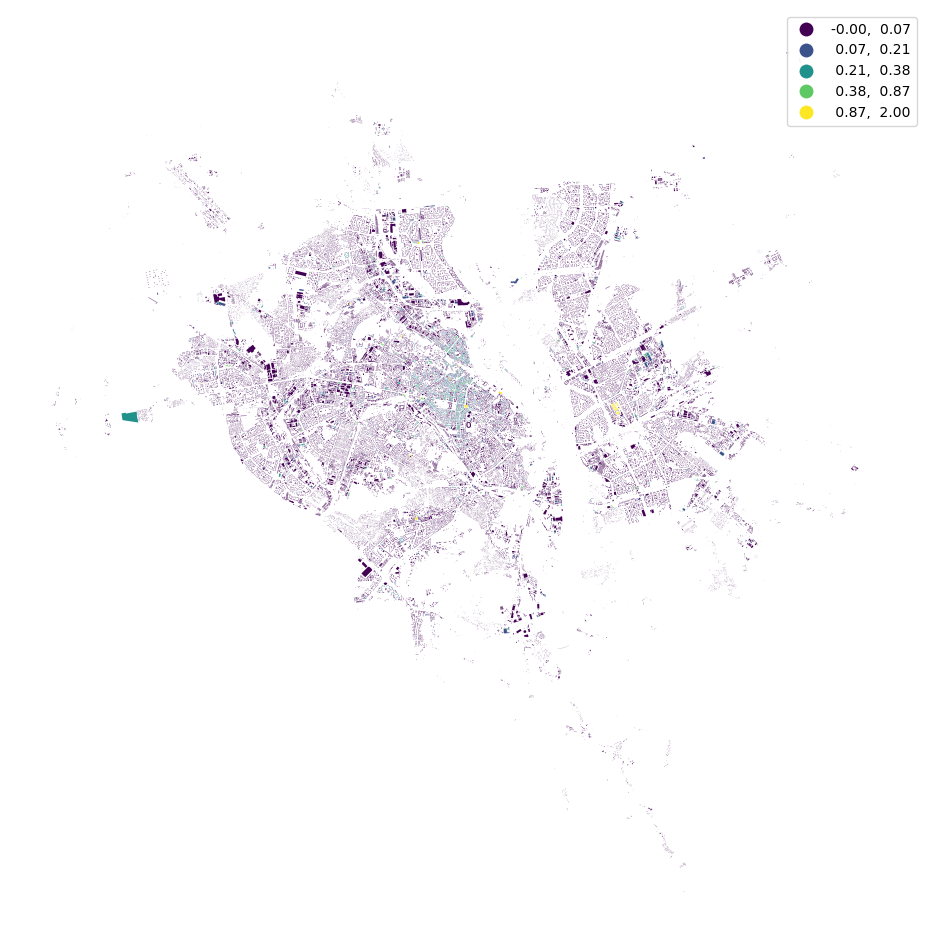

In [50]:
buildings["shared_walls"] = momepy.SharedWallsRatio(buildings).series
buildings.plot("shared_walls", figsize=(12, 12), scheme="natural_breaks", legend=True).set_axis_off()

In [51]:
queen_1 = libpysal.weights.contiguity.Queen.from_dataframe(tessellation, ids="uID", silence_warnings=True)

In [52]:
tessellation["neighbors"] = momepy.Neighbors(tessellation, queen_1, "uID", weighted=True, verbose=False).series
tessellation["covered_area"] = momepy.CoveredArea(tessellation, queen_1, "uID", verbose=False).series

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    buildings["neighbor_distance"] = momepy.NeighborDistance(buildings, queen_1, "uID", verbose=False).series

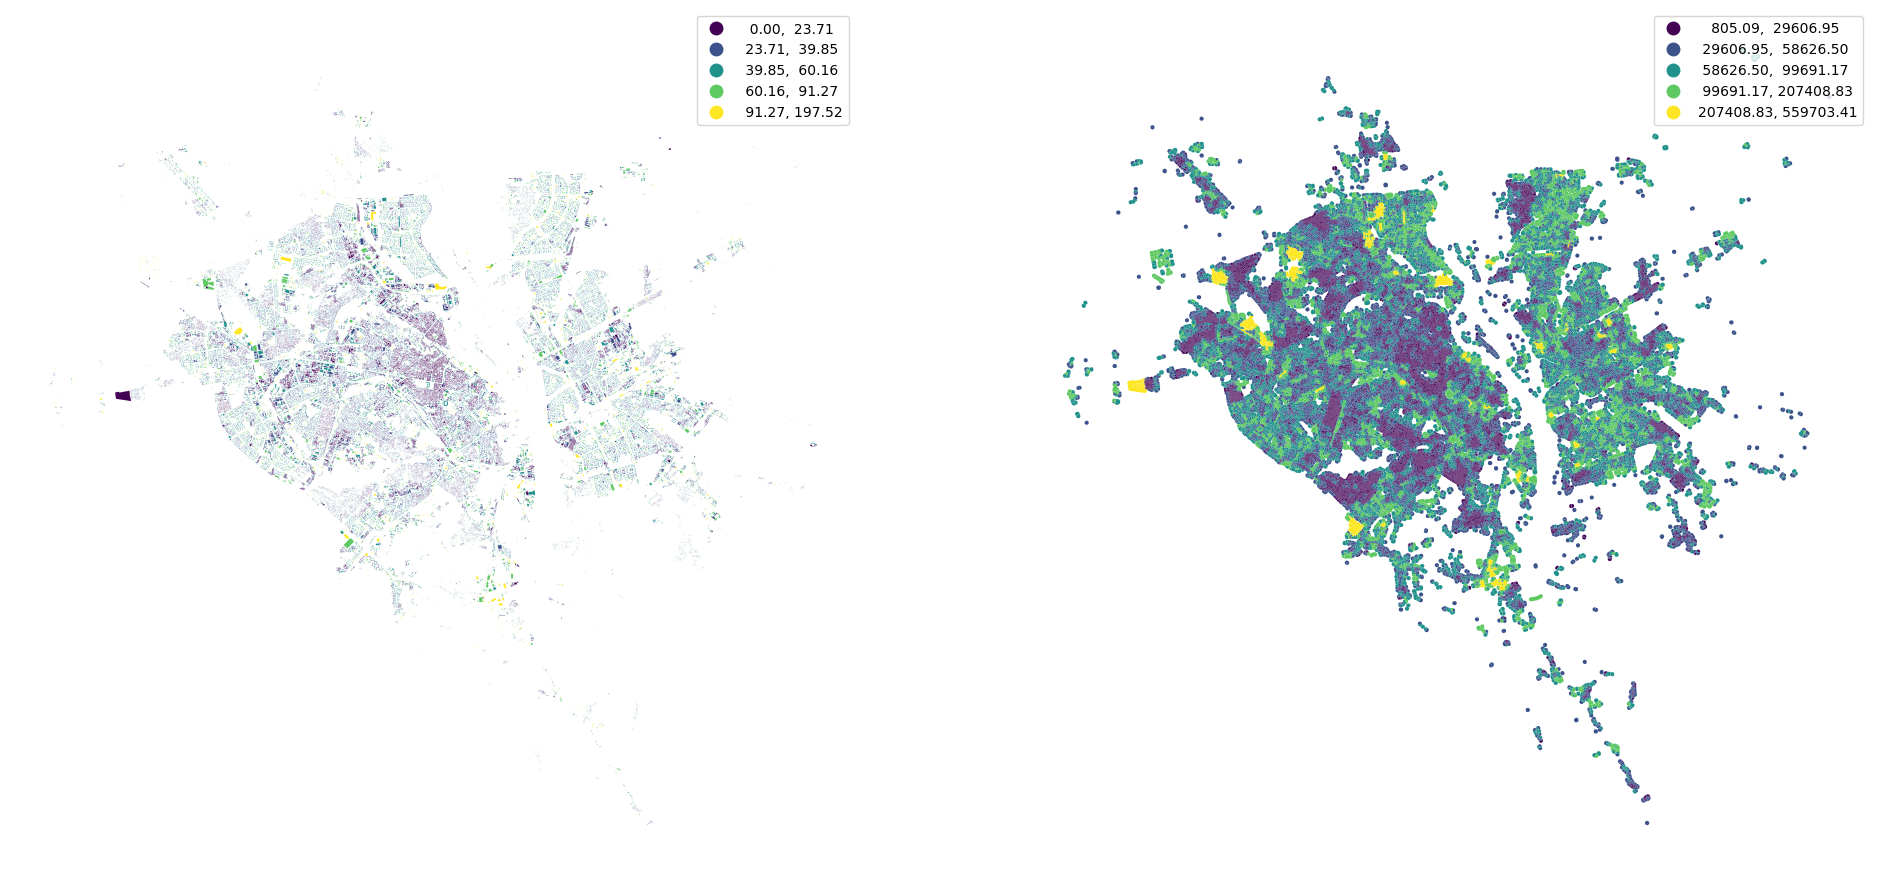

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

buildings.plot("neighbor_distance", ax=ax[0], scheme="natural_breaks", legend=True)
tessellation.plot("covered_area", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_axis_off()
ax[1].set_axis_off()

In [54]:
queen_3 = momepy.sw_high(k=3, weights=queen_1)
buildings_q1 = libpysal.weights.contiguity.Queen.from_dataframe(buildings, silence_warnings=True)

buildings['interbuilding_distance'] = momepy.MeanInterbuildingDistance(buildings, queen_1, 'uID', queen_3, verbose=False).series
buildings['adjacency'] = momepy.BuildingAdjacency(buildings, queen_3, 'uID', buildings_q1, verbose=False).series

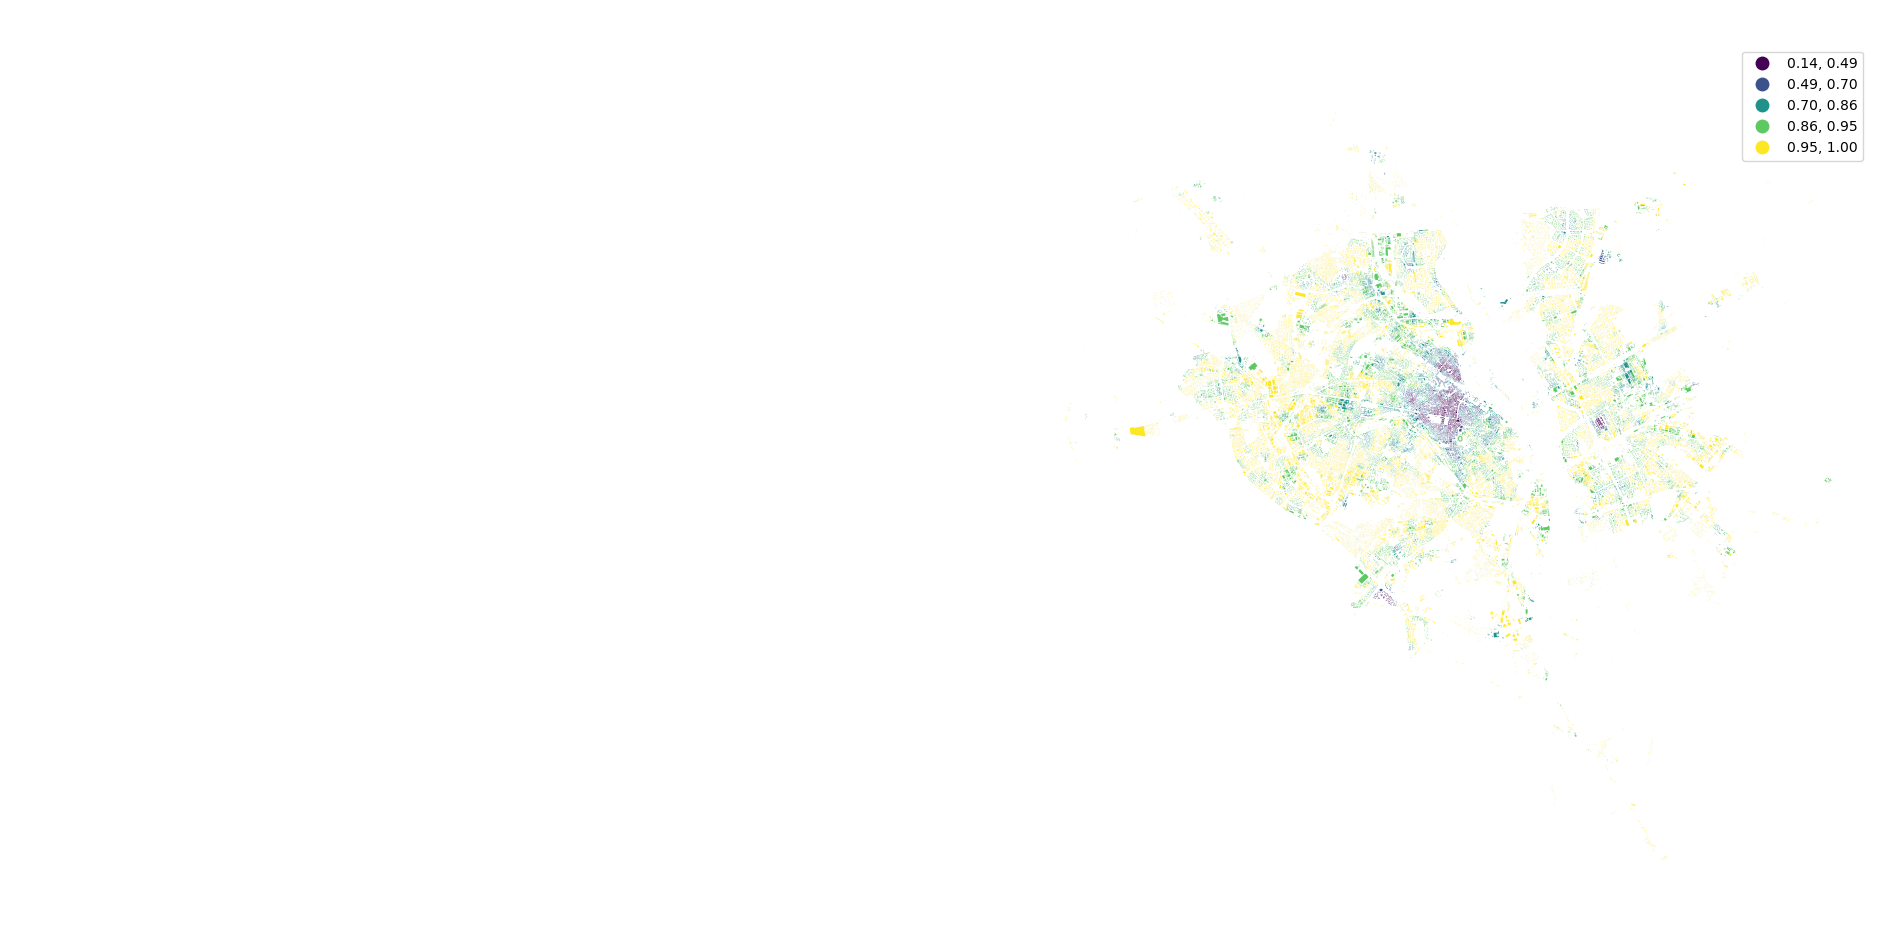

In [56]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

# buildings.plot("interbuilding_distance", ax=ax[0], scheme="natural_breaks", legend=True)
buildings.plot("adjacency", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_axis_off()
ax[1].set_axis_off()

In [57]:
profile = momepy.StreetProfile(streets, buildings)
streets["width"] = profile.w
streets["width_deviation"] = profile.wd
streets["openness"] = profile.o

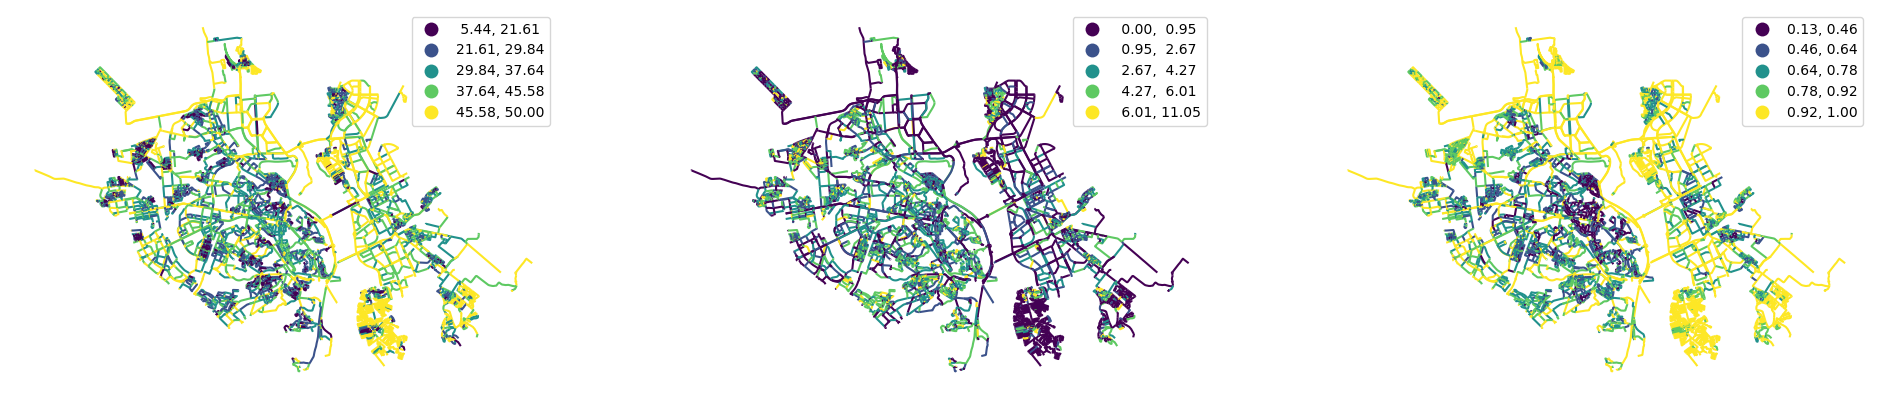

In [58]:
fig, ax = plt.subplots(1, 3, figsize=(24, 12))

streets.plot("width", ax=ax[0], scheme="natural_breaks", legend=True)
streets.plot("width_deviation", ax=ax[1], scheme="natural_breaks", legend=True)
streets.plot("openness", ax=ax[2], scheme="natural_breaks", legend=True)

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()

## Intensity

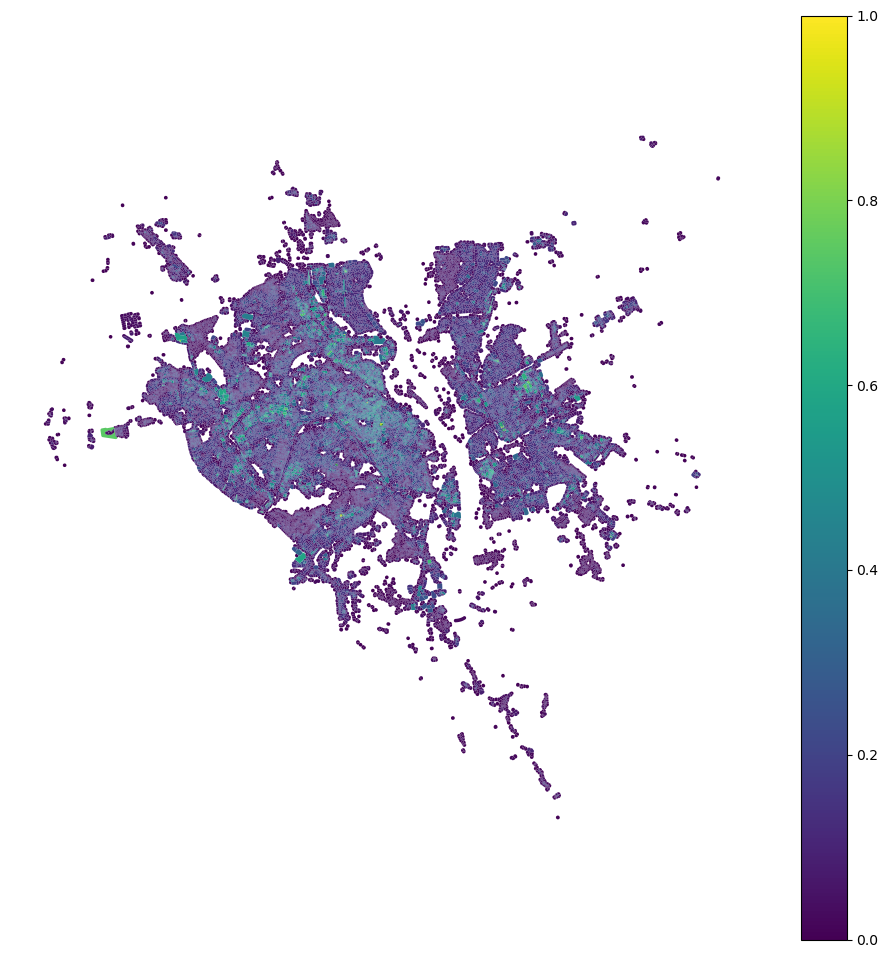

In [59]:
tessellation['car'] = momepy.AreaRatio(tessellation, buildings, 'area', 'area', 'uID').series
tessellation.plot("car", figsize=(12, 12), vmin=0, vmax=1, legend=True).set_axis_off()

## Connectivity

In [60]:
graph = momepy.gdf_to_nx(streets)
graph = momepy.node_degree(graph)
graph = momepy.closeness_centrality(graph, radius=400, distance="mm_len")
graph = momepy.meshedness(graph, radius=400, distance="mm_len")
nodes, streets = momepy.nx_to_gdf(graph)

  0%|          | 0/6112 [00:00<?, ?it/s]

  0%|          | 0/6112 [00:00<?, ?it/s]

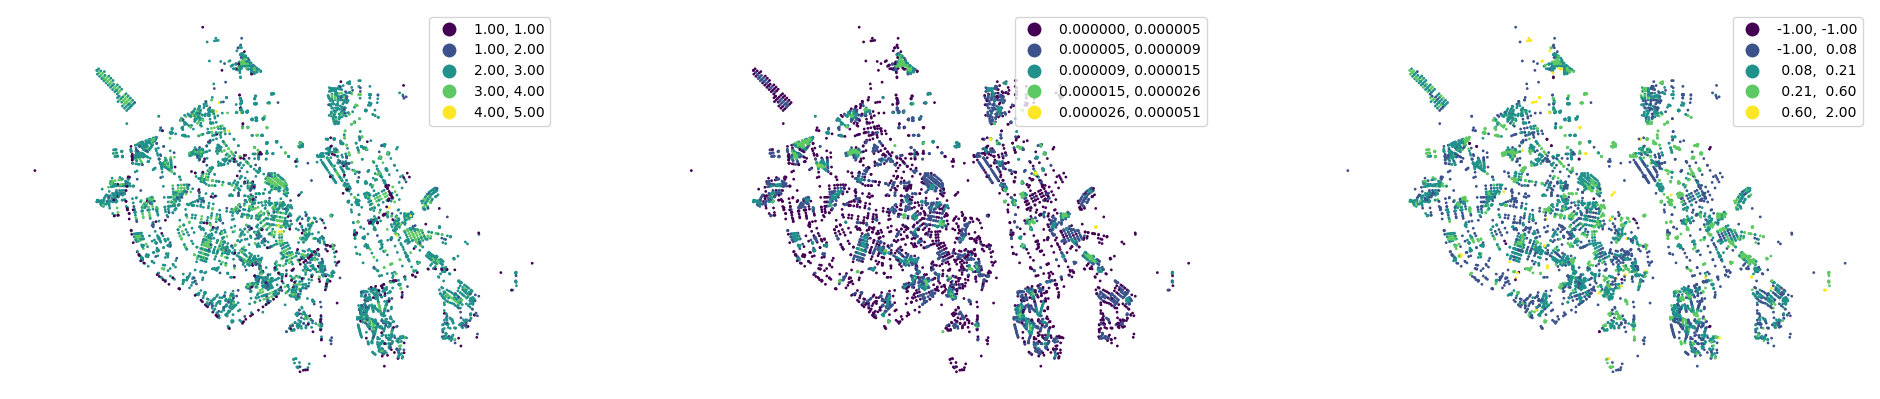

In [61]:
fig, ax = plt.subplots(1, 3, figsize=(24, 12))

nodes.plot("degree", ax=ax[0], scheme="natural_breaks", legend=True, markersize=1)
nodes.plot("closeness", ax=ax[1], scheme="natural_breaks", legend=True, markersize=1, legend_kwds={"fmt": "{:.6f}"})
nodes.plot("meshedness", ax=ax[2], scheme="natural_breaks", legend=True, markersize=1)

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()

In [62]:
buildings["nodeID"] = momepy.get_node_id(buildings, nodes, streets, "nodeID", "nID")

  0%|          | 0/59261 [00:00<?, ?it/s]

In [63]:
# Link all data together (to tessellation cells or buildings).

merged = tessellation.merge(buildings.drop(columns=['nID', 'geometry']), on='uID')
merged = merged.merge(streets.drop(columns='geometry'), on='nID', how='left')
merged = merged.merge(nodes.drop(columns='geometry'), on='nodeID', how='left')
merged.columns

Index(['uID', 'geometry', 'nID', 'area_x', 'convexity', 'neighbors',
       'covered_area', 'car', 'area_y', 'eri', 'elongation', 'shared_walls',
       'neighbor_distance', 'interbuilding_distance', 'adjacency', 'nodeID',
       'length', 'linearity', 'width', 'width_deviation', 'openness', 'mm_len',
       'node_start', 'node_end', 'degree', 'closeness', 'meshedness'],
      dtype='object')

# Understanding the context

In [64]:
# Measure first, second and third quartile of distribution of values within an area around each building.
percentiles = []
for column in merged.columns.drop(["uID", "nodeID", "nID", 'mm_len', 'node_start', 'node_end', "geometry"]):
    perc = momepy.Percentiles(merged, column, queen_3, "uID", verbose=False).frame
    perc.columns = [f"{column}_" + str(x) for x in perc.columns]
    percentiles.append(perc)

In [65]:
percentiles_joined = pandas.concat(percentiles, axis=1)
percentiles_joined.head()

area_x_25     area_x_50     area_x_75  convexity_25  convexity_50  \
0  39802.278366  39802.278366  39802.278366      0.999965      0.999965   
1   2564.702101   3999.754301  10462.207725      0.946044      0.958392   
2   2564.702101   4590.891819  12026.339655      0.946044      0.956165   
3  10565.228981  11878.387906  17149.101644      0.968101      0.986677   
4   2204.747580   3171.369192   9910.722226      0.937836      0.977670   

   convexity_75  neighbors_25  neighbors_50  neighbors_75  covered_area_25  \
0      0.999965      0.000000      0.000000      0.000000     39802.278366   
1      0.972173      0.011092      0.015422      0.027245     26859.084362   
2      0.967088      0.009186      0.013662      0.028589     27049.679848   
3      0.994536      0.005823      0.006989      0.008716     58493.281172   
4      0.987824      0.013009      0.019730      0.023826     26188.982511   

   ...  openness_75  degree_25  degree_50  degree_75  closeness_25  \
0  ...          NaN        NaN        NaN        NaN           NaN   
1  ...          NaN        NaN        NaN        NaN           NaN   
2  ...          NaN        NaN        NaN        NaN           NaN   
3  ...          NaN        NaN        NaN        NaN           NaN   
4  ...          NaN        NaN        NaN        NaN           NaN   

   closeness_50  closeness_75  meshedness_25  meshedness_50  meshedness_75  
0           NaN           NaN            NaN            NaN            NaN  
1           NaN           NaN            NaN            NaN            NaN  
2           NaN           NaN            NaN            NaN            NaN  
3           NaN           NaN            NaN            NaN            NaN  
4           NaN           NaN            NaN            NaN            NaN  

[5 rows x 60 columns]

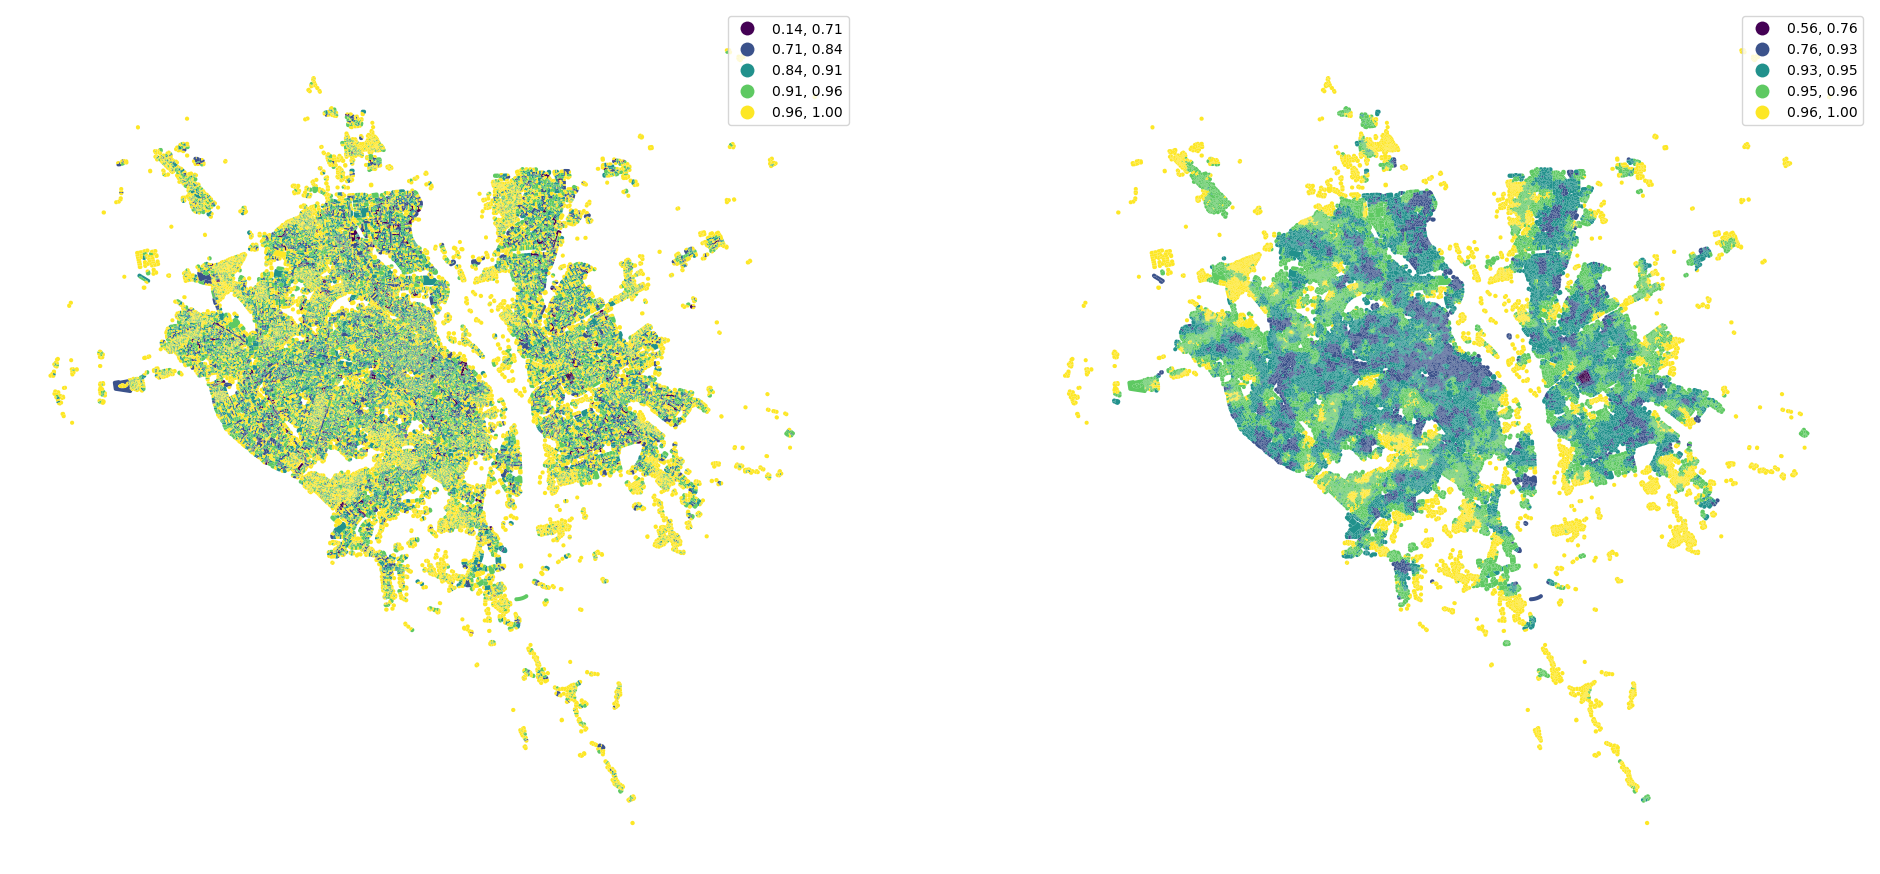

In [66]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

tessellation.plot("convexity", ax=ax[0], scheme="natural_breaks", legend=True)
merged.plot(percentiles_joined['convexity_50'].values, ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_axis_off()
ax[1].set_axis_off()

# Clustering

In [68]:
standardized = (percentiles_joined - percentiles_joined.mean()) / percentiles_joined.std()
standardized.head()

area_x_25  area_x_50  area_x_75  convexity_25  convexity_50  convexity_75  \
0  13.080663   9.682024   6.345058      2.718450      2.526401      2.627567   
1  -0.094030  -0.163565   0.565006      1.119534      0.491792     -0.071024   
2  -0.094030  -0.001003   0.873143      1.119534      0.382811     -0.564805   
3   2.736565   2.003036   1.882337      1.773607      1.876084      2.100482   
4  -0.221382  -0.391368   0.456362      0.876161      1.435297      1.448697   

   neighbors_25  neighbors_50  neighbors_75  covered_area_25  ...  \
0     -2.580313     -2.815621     -3.034653         0.721020  ...   
1     -1.071434     -0.987023     -0.204281        -0.061875  ...   
2     -1.330751     -1.195682     -0.064600        -0.050346  ...   
3     -1.788185     -1.986952     -2.129227         1.851583  ...   
4     -0.810729     -0.476309     -0.559503        -0.102407  ...   

   openness_75  degree_25  degree_50  degree_75  closeness_25  closeness_50  \
0          NaN        NaN        NaN        NaN           NaN           NaN   
1          NaN        NaN        NaN        NaN           NaN           NaN   
2          NaN        NaN        NaN        NaN           NaN           NaN   
3          NaN        NaN        NaN        NaN           NaN           NaN   
4          NaN        NaN        NaN        NaN           NaN           NaN   

   closeness_75  meshedness_25  meshedness_50  meshedness_75  
0           NaN            NaN            NaN            NaN  
1           NaN            NaN            NaN            NaN  
2           NaN            NaN            NaN            NaN  
3           NaN            NaN            NaN            NaN  
4           NaN            NaN            NaN            NaN  

[5 rows x 60 columns]

In [69]:
cgram = Clustergram(range(1, 12), n_init=10, random_state=42)
cgram.fit(standardized.fillna(0))

show(cgram.bokeh())

K=1 skipped. Mean computed from data directly.
K=2 fitted in 0.470 seconds.
K=3 fitted in 1.294 seconds.
K=4 fitted in 0.623 seconds.
K=5 fitted in 0.831 seconds.
K=6 fitted in 1.239 seconds.
K=7 fitted in 1.327 seconds.
K=8 fitted in 1.363 seconds.
K=9 fitted in 2.030 seconds.
K=10 fitted in 1.877 seconds.
K=11 fitted in 2.900 seconds.


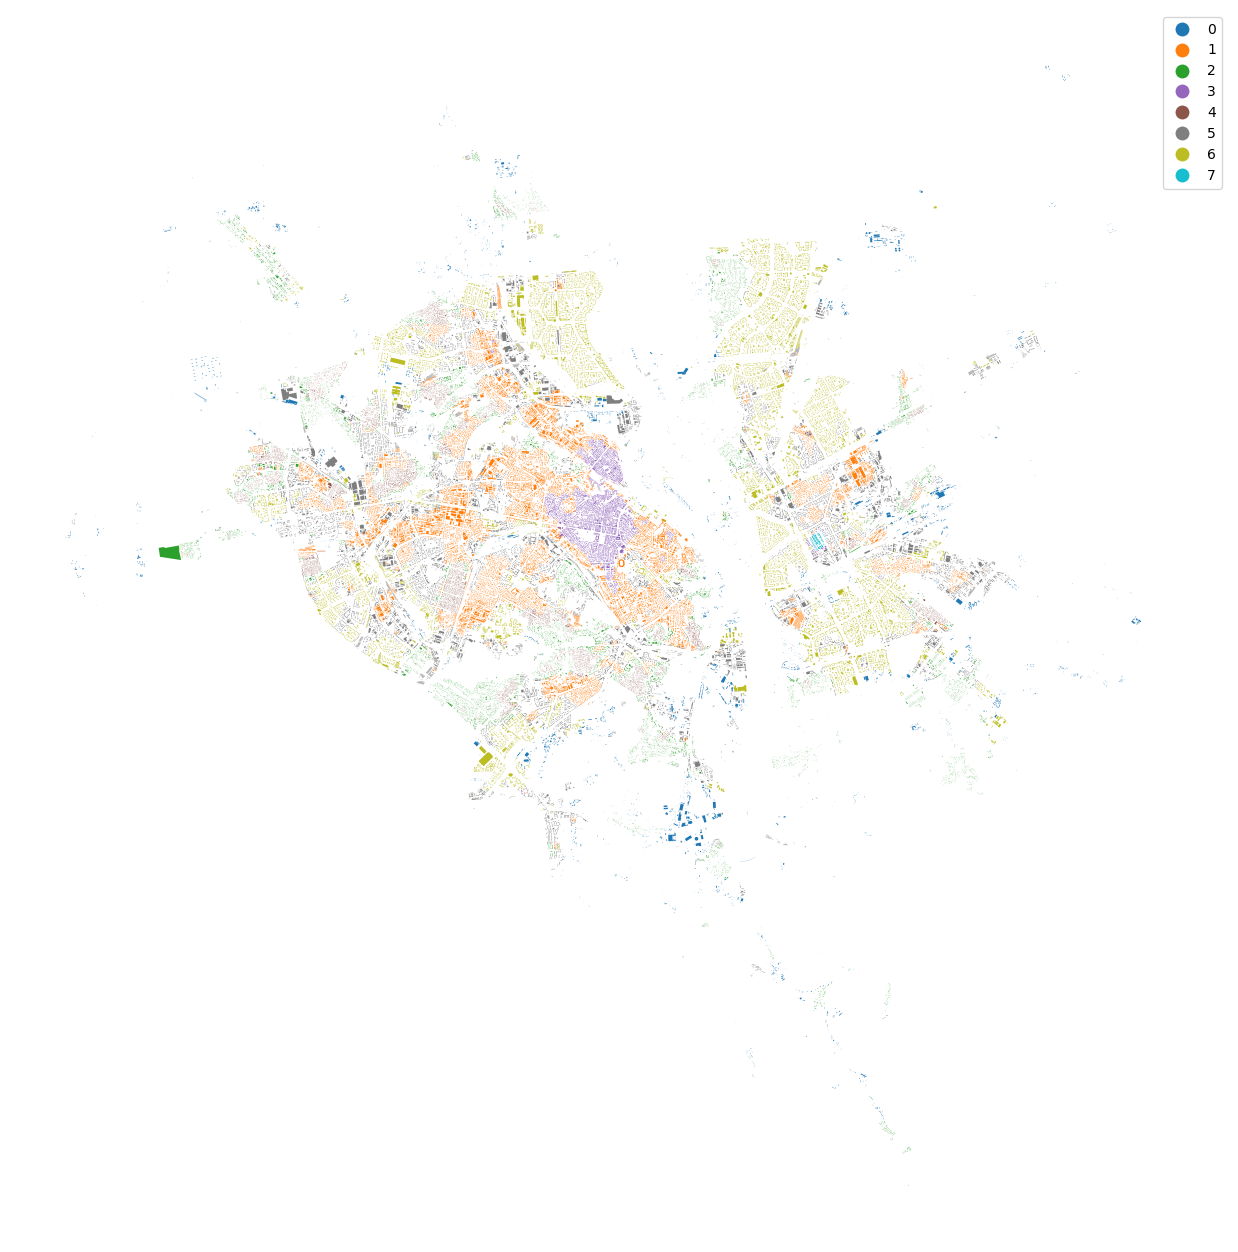

In [72]:
merged["cluster"] = cgram.labels[8].values
urban_types = buildings[["geometry", "uID"]].merge(merged[["uID", "cluster"]], on="uID")
urban_types.plot("cluster", categorical=True, figsize=(16, 16), legend=True).set_axis_off()

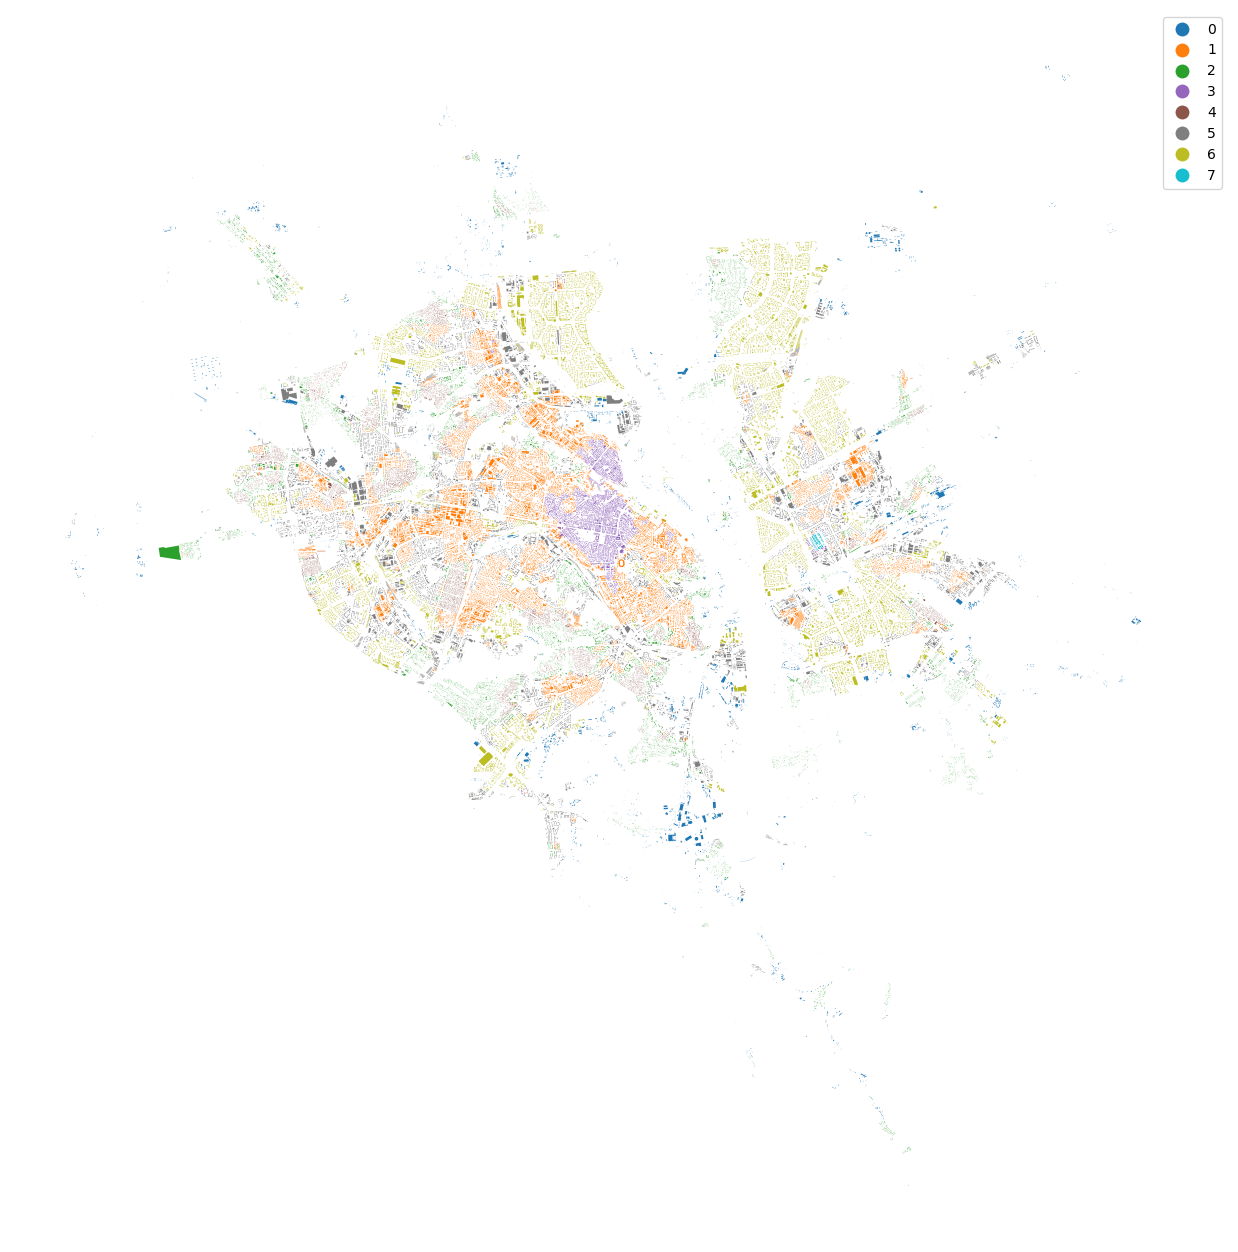

In [80]:
ax = urban_types.plot("cluster", categorical=True, figsize=(16, 16), legend=True)
# ax.set_xlim(-645000, -641000)
# ax.set_ylim(-1195500, -1191000)
ax.set_axis_off()